# House Price Prediction - EDA & Feature Engineering

This notebook covers:
1. Data loading and initial exploration
2. Missing value analysis
3. Target variable (Price) analysis
4. Categorical and numerical feature analysis
5. Temporal patterns
6. Feature engineering with rationale

In [5]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl", "matplotlib", "seaborn", "--quiet"])

0

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Data

In [7]:
data_path = Path('../Case Study 1 Data (1).xlsx')
df = pd.read_excel(data_path)
print(f"Dataset: {len(df):,} rows, {len(df.columns)} columns")
df.head()

Dataset: 247,172 rows, 10 columns


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0
3,SI_000004,CityB,1930.0,2.0,3.0,1905.0,Good,Single Family,2021-12-09,651000.0
4,SI_000005,CityB,1895.0,5.0,2.0,1936.0,New,Single Family,2024-10-30,1878000.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247172 entries, 0 to 247171
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Property ID  247172 non-null  object        
 1   Location     247172 non-null  object        
 2   Size         244701 non-null  float64       
 3   Bedrooms     238769 non-null  float64       
 4   Bathrooms    240499 non-null  float64       
 5   Year Built   234567 non-null  float64       
 6   Condition    236544 non-null  object        
 7   Type         247172 non-null  object        
 8   Date Sold    247172 non-null  datetime64[ns]
 9   Price        241735 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 18.9+ MB


In [9]:
df.describe()

,Size,Bedrooms,Bathrooms,Year Built,Date Sold,Price
count,244701.000000,238769.000000,240499.000000,234567.000000,247172,2.417350e+05
mean,2402.547664,3.000457,2.002823,1961.429191,2022-07-02 05:00:11.127473664,4.660883e+05
min,800.000000,1.000000,1.000000,1900.000000,2020-01-01 00:00:00,2.600000e+04
25%,1603.000000,2.000000,1.000000,1931.000000,2021-04-02 00:00:00,3.000000e+05
50%,2404.000000,3.000000,2.000000,1961.000000,2022-07-03 00:00:00,4.170000e+05
75%,3203.000000,4.000000,3.000000,1992.000000,2023-10-02 00:00:00,5.770000e+05
max,3999.000000,5.000000,3.000000,2023.000000,2024-12-31 00:00:00,2.223000e+06
std,923.418566,1.415088,0.816616,35.752638,NaN,2.315026e+05


## 2. Missing Values Analysis

Understanding missing data is critical before modeling. High missing rates may indicate data quality issues or systematic collection problems.

In [10]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'column': missing.index,
    'count': missing.values,
    'percent': missing_pct.values
})
missing_df = missing_df[missing_df['count'] > 0].sort_values('count', ascending=False)
missing_df

,column,count,percent
5,Year Built,12605,5.1
6,Condition,10628,4.3
3,Bedrooms,8403,3.4
4,Bathrooms,6673,2.7
9,Price,5437,2.2
2,Size,2471,1.0


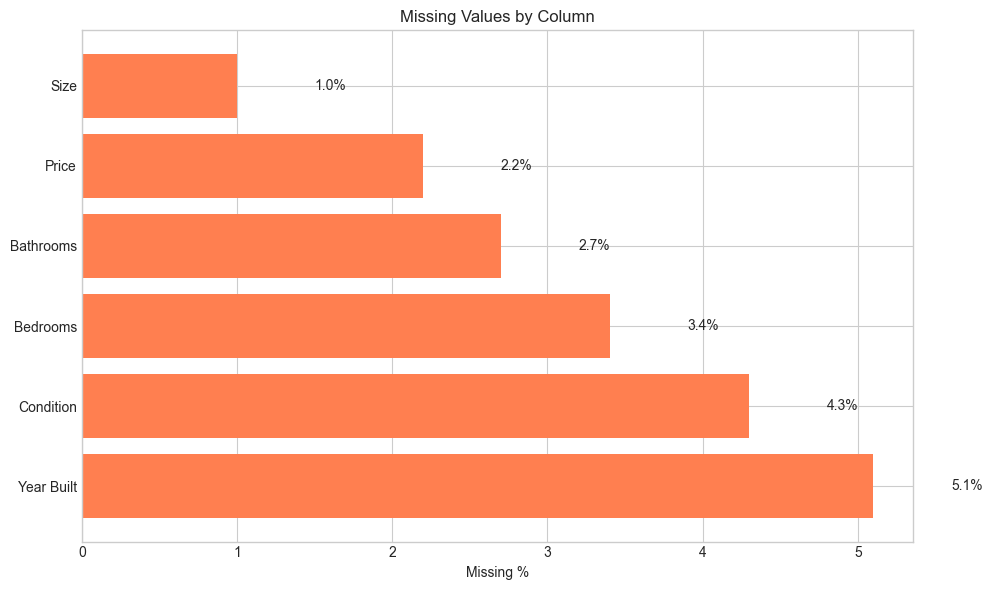

In [11]:
# visualize missing values
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(missing_df['column'], missing_df['percent'], color='coral')
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Values by Column')
    
    for bar, pct in zip(bars, missing_df['percent']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', va='center')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found.")

## 3. Target Variable Analysis (Price)

Examining the price distribution helps us understand:
- Whether we need log transformation (common for prices which are right-skewed)
- Outlier detection
- Central tendency measures

In [12]:
print("Price Statistics:")
print(f"  Mean:   ${df['Price'].mean():,.0f}")
print(f"  Median: ${df['Price'].median():,.0f}")
print(f"  Std:    ${df['Price'].std():,.0f}")
print(f"  Min:    ${df['Price'].min():,.0f}")
print(f"  Max:    ${df['Price'].max():,.0f}")
print(f"  Skew:   {df['Price'].skew():.2f}")

Price Statistics:
  Mean:   $466,088
  Median: $417,000
  Std:    $231,503
  Min:    $26,000
  Max:    $2,223,000
  Skew:   1.39


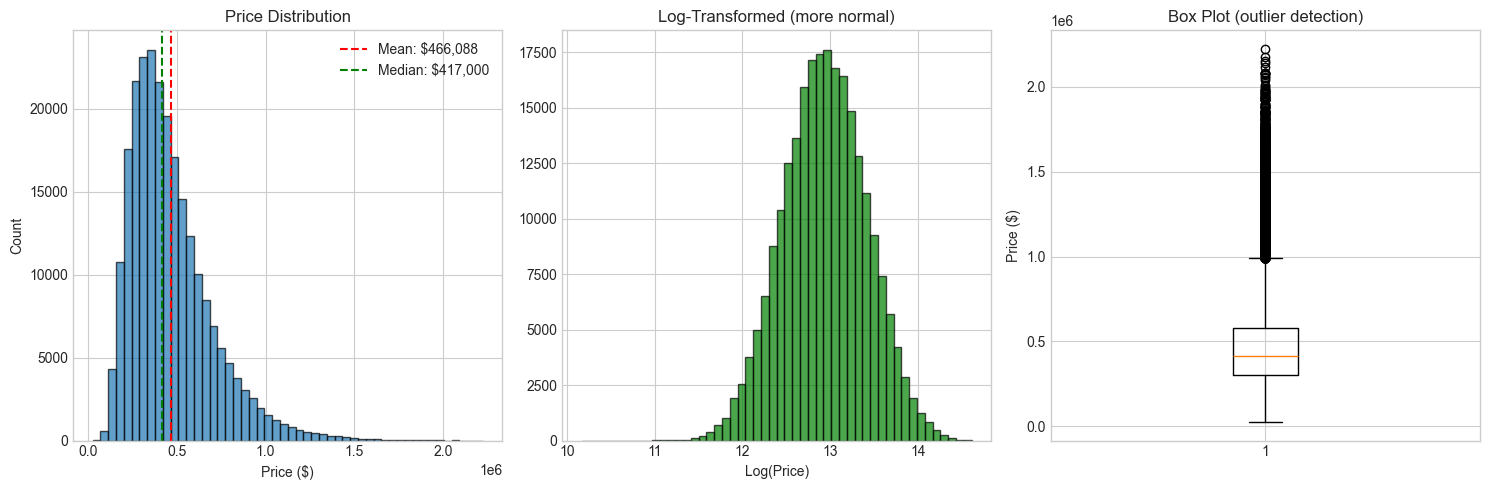

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# raw distribution
axes[0].hist(df['Price'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Count')
axes[0].set_title('Price Distribution')
axes[0].axvline(df['Price'].mean(), color='red', linestyle='--', label=f"Mean: ${df['Price'].mean():,.0f}")
axes[0].axvline(df['Price'].median(), color='green', linestyle='--', label=f"Median: ${df['Price'].median():,.0f}")
axes[0].legend()

# log transform - often useful for price prediction
axes[1].hist(np.log1p(df['Price'].dropna()), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price)')
axes[1].set_title('Log-Transformed (more normal)')

# boxplot for outliers
axes[2].boxplot(df['Price'].dropna())
axes[2].set_ylabel('Price ($)')
axes[2].set_title('Box Plot (outlier detection)')

plt.tight_layout()
plt.show()

## 4. Categorical Features Analysis

Analyzing Location, Condition, and Type to understand:
- Class distribution (imbalanced classes need special handling)
- Price variation across categories (feature importance signal)

In [14]:
cat_cols = ['Location', 'Condition', 'Type']
for col in cat_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


Location:
Location
CityC    62082
CityA    61916
CityD    61724
CityB    61450
Name: count, dtype: int64

Condition:
Condition
Good    94629
Fair    71194
Poor    47244
New     23477
Name: count, dtype: int64

Type:
Type
Townhouse        100000
Single Family     88261
Condominium       58911
Name: count, dtype: int64


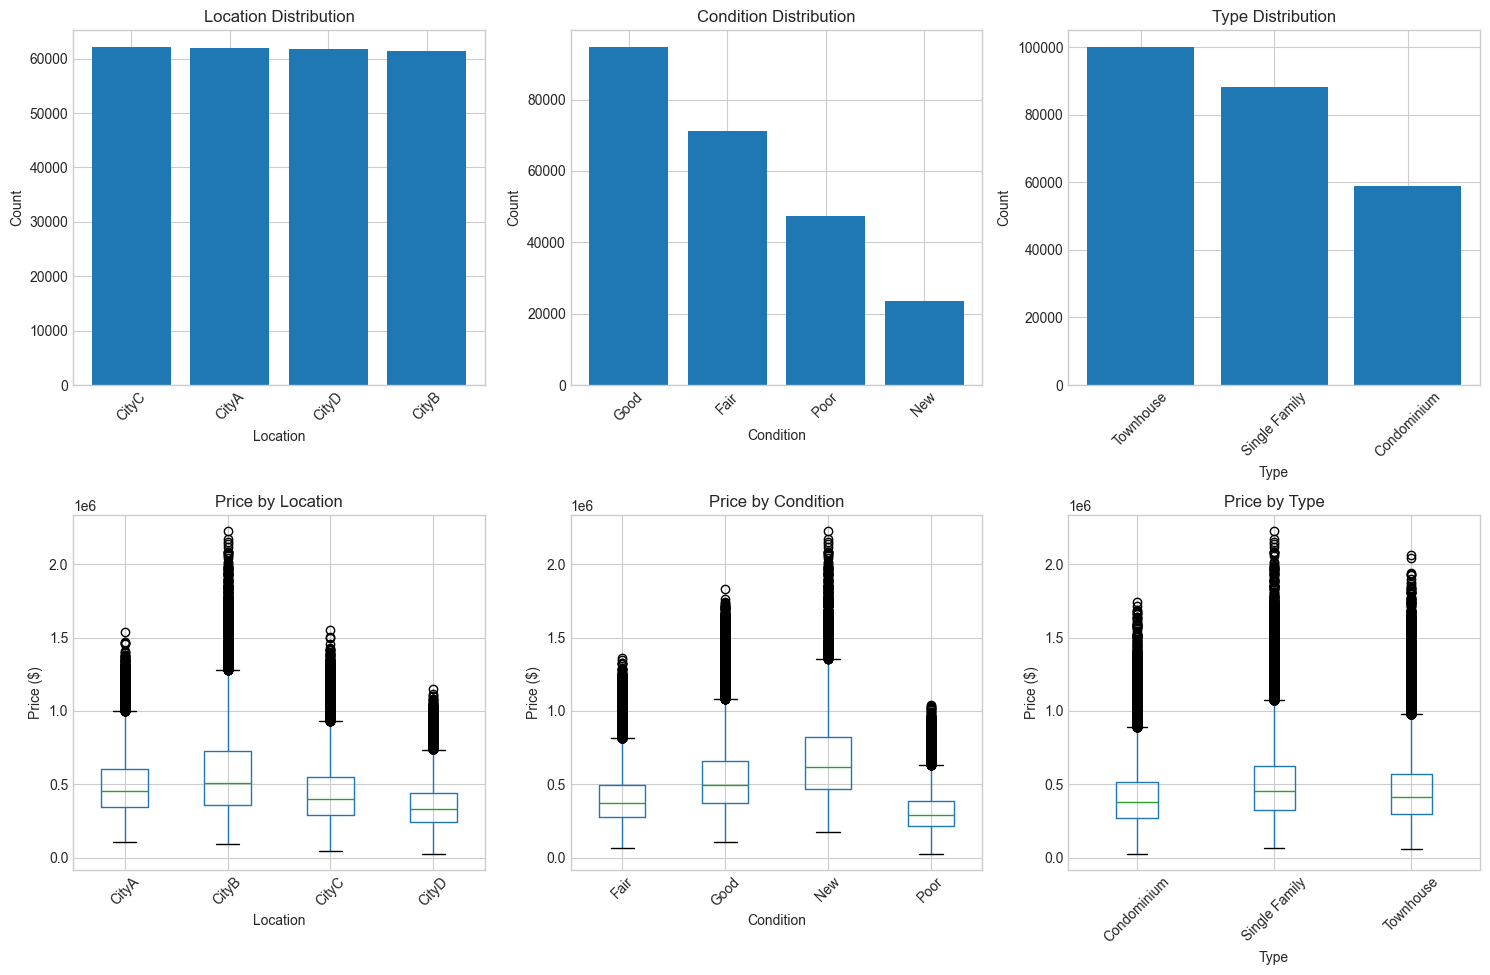

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(cat_cols):
    # distribution
    ax = axes[0, i]
    counts = df[col].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'{col} Distribution')
    ax.tick_params(axis='x', rotation=45)

    # price by category
    ax = axes[1, i]
    df.dropna(subset=[col, 'Price']).boxplot(column='Price', by=col, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Price ($)')
    ax.set_title(f'Price by {col}')
    ax.tick_params(axis='x', rotation=45)
    plt.suptitle('')

plt.tight_layout()
plt.show()

## 5. Numerical Features Analysis

Examining Size, Bedrooms, Bathrooms, Year Built for:
- Distribution shape
- Correlation with price
- Potential for derived features

In [16]:
num_cols = ['Size', 'Bedrooms', 'Bathrooms', 'Year Built']
df[num_cols].describe()

,Size,Bedrooms,Bathrooms,Year Built
count,244701.000000,238769.000000,240499.000000,234567.000000
mean,2402.547664,3.000457,2.002823,1961.429191
std,923.418566,1.415088,0.816616,35.752638
min,800.000000,1.000000,1.000000,1900.000000
25%,1603.000000,2.000000,1.000000,1931.000000
50%,2404.000000,3.000000,2.000000,1961.000000
75%,3203.000000,4.000000,3.000000,1992.000000
max,3999.000000,5.000000,3.000000,2023.000000


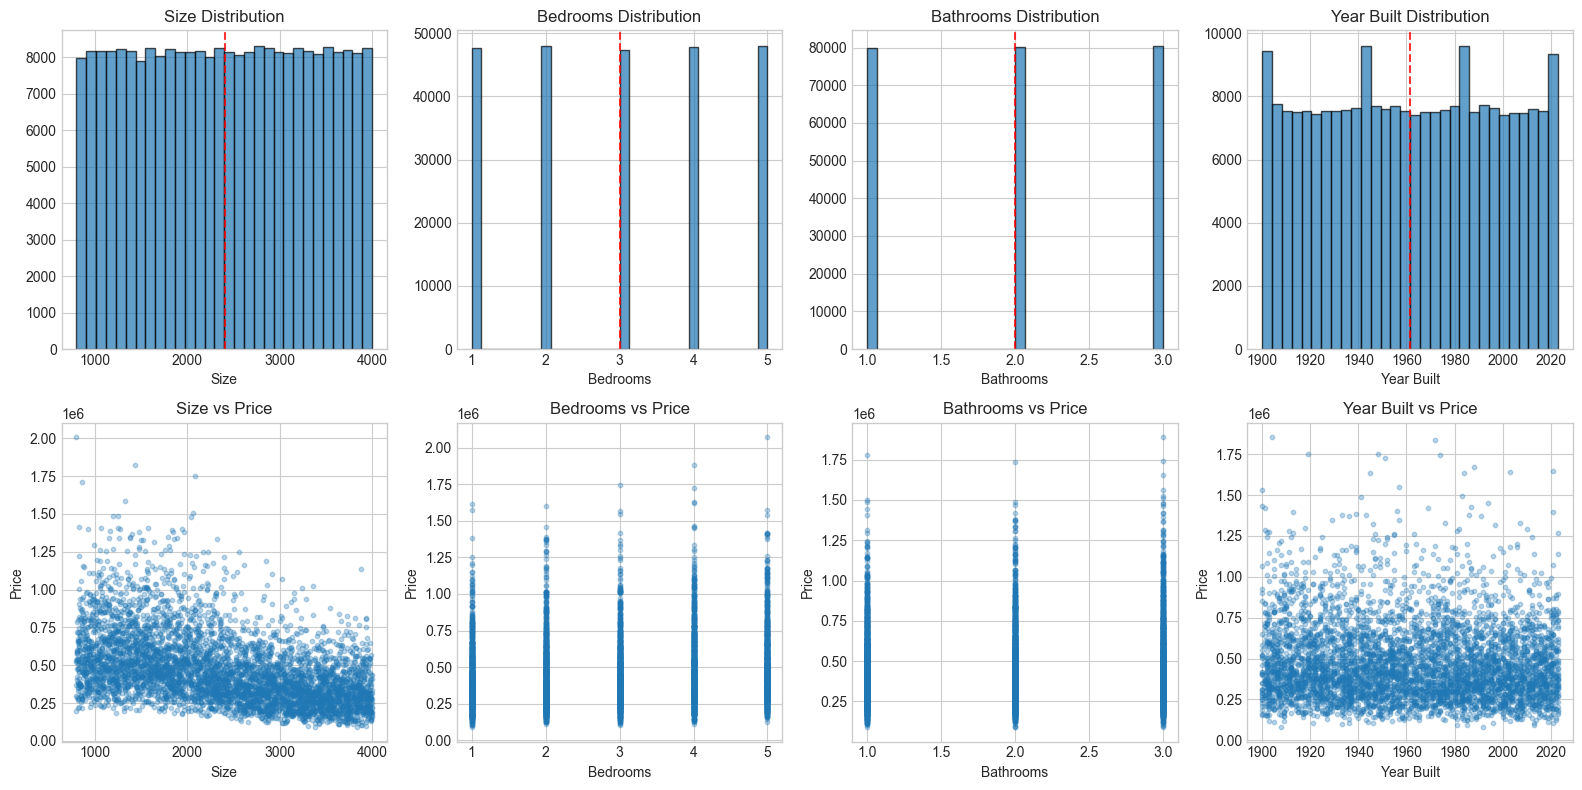

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(num_cols):
    # distribution
    data = df[col].dropna()
    axes[0, i].hist(data, bins=30, edgecolor='black', alpha=0.7)
    axes[0, i].set_xlabel(col)
    axes[0, i].set_title(f'{col} Distribution')
    axes[0, i].axvline(data.mean(), color='red', linestyle='--', alpha=0.8)

    # scatter vs price
    sample = df.dropna(subset=[col, 'Price']).sample(min(5000, len(df)), random_state=42)
    axes[1, i].scatter(sample[col], sample['Price'], alpha=0.3, s=10)
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel('Price')
    axes[1, i].set_title(f'{col} vs Price')

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

Understanding feature relationships helps:
- Identify multicollinearity (problematic for linear models)
- Find strong predictors of price
- Guide feature engineering decisions

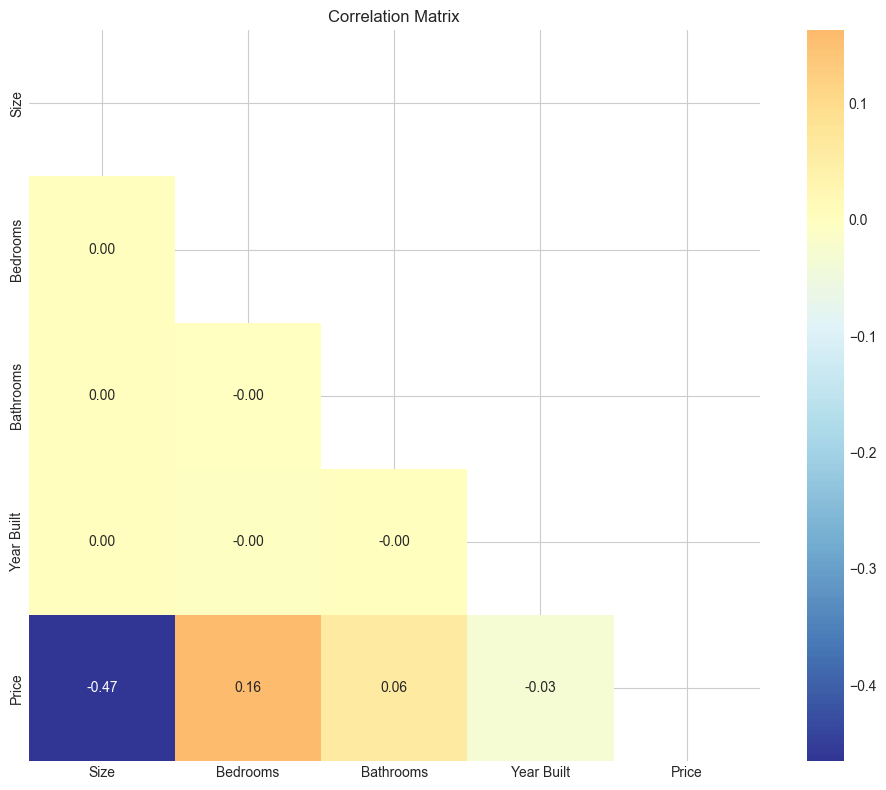


Correlation with Price:
Price         1.000000
Bedrooms      0.162446
Bathrooms     0.057608
Year Built   -0.030181
Size         -0.465010
Name: Price, dtype: float64


In [18]:
cols = ['Size', 'Bedrooms', 'Bathrooms', 'Year Built', 'Price']
corr = df[cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, ax=ax)
ax.set_title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with Price:")
print(corr['Price'].sort_values(ascending=False))

## 7. Temporal Analysis

Time-based patterns are crucial for real estate:
- Market trends over years
- Seasonality (spring/summer typically higher sales)
- Price appreciation over time

In [19]:
print(f"Date Range: {df['Date Sold'].min().date()} to {df['Date Sold'].max().date()}")

Date Range: 2020-01-01 to 2024-12-31


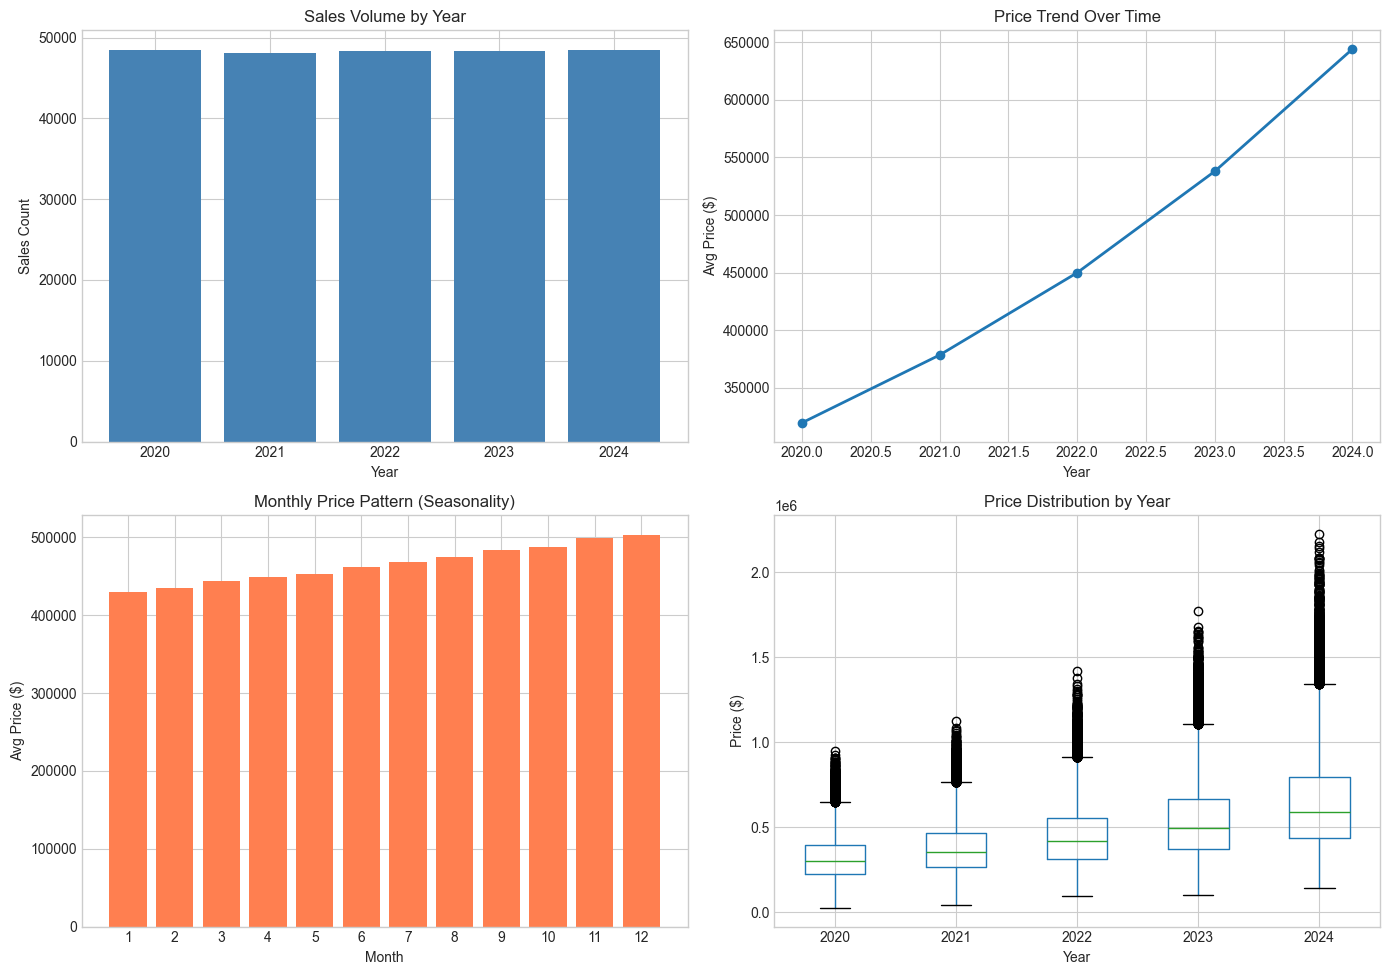

In [20]:
tmp = df.dropna(subset=['Date Sold', 'Price']).copy()
tmp['year'] = tmp['Date Sold'].dt.year
tmp['month'] = tmp['Date Sold'].dt.month

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# sales volume by year
yearly = tmp.groupby('year').size()
axes[0, 0].bar(yearly.index, yearly.values, color='steelblue')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Sales Count')
axes[0, 0].set_title('Sales Volume by Year')

# avg price trend
yearly_price = tmp.groupby('year')['Price'].mean()
axes[0, 1].plot(yearly_price.index, yearly_price.values, marker='o', linewidth=2)
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Avg Price ($)')
axes[0, 1].set_title('Price Trend Over Time')

# monthly seasonality
monthly = tmp.groupby('month')['Price'].mean()
axes[1, 0].bar(monthly.index, monthly.values, color='coral')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Avg Price ($)')
axes[1, 0].set_title('Monthly Price Pattern (Seasonality)')
axes[1, 0].set_xticks(range(1, 13))

# price distribution by year
tmp.boxplot(column='Price', by='year', ax=axes[1, 1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price Distribution by Year')
plt.suptitle('')

plt.tight_layout()
plt.show()

---

# Feature Engineering

Based on the EDA insights, we create new features to capture:
1. **Property characteristics** not directly in raw data
2. **Temporal patterns** that affect pricing
3. **Interaction effects** between features
4. **Domain knowledge** from real estate

In [21]:
# work with a copy
data = df.copy()

### Feature 1: Property Age

**Why?** Newer properties typically command higher prices. Age at time of sale is more relevant than just year built because it captures the actual condition/depreciation state when sold.

In [22]:
data['property_age'] = data['Date Sold'].dt.year - data['Year Built']
data['property_age'] = data['property_age'].clip(lower=0)  # handle edge cases

print(f"Property Age: min={data['property_age'].min()}, max={data['property_age'].max()}, mean={data['property_age'].mean():.1f}")

Property Age: min=0.0, max=124.0, mean=60.6


### Feature 2: Age Bucket

**Why?** Price-age relationship is often non-linear. New homes (0-10 yrs) have a premium, mid-age (11-40) are standard, and older (40+) may have character value or need updates. Categorical buckets capture these segments.

In [23]:
data['age_bucket'] = pd.cut(
    data['property_age'],
    bins=[-1, 10, 40, 200],
    labels=['new', 'mid', 'old']
)

print(data['age_bucket'].value_counts())

age_bucket
old    155287
mid     56739
new     22541
Name: count, dtype: int64


### Feature 3: Is New Property

**Why?** Properties built within 5 years of sale date often have a "new construction" premium - modern amenities, warranties, no deferred maintenance.

In [24]:
data['is_new'] = (data['property_age'] <= 5).astype(int)

print(f"New properties: {data['is_new'].sum():,} ({data['is_new'].mean()*100:.1f}%)")

New properties: 13,113 (5.3%)


### Feature 4: Total Rooms

**Why?** Total room count (bedrooms + bathrooms) is a proxy for overall living space and functionality. More rooms = more value.

In [25]:
data['total_rooms'] = data['Bedrooms'] + data['Bathrooms']

print(f"Total Rooms: min={data['total_rooms'].min()}, max={data['total_rooms'].max()}, mean={data['total_rooms'].mean():.1f}")

Total Rooms: min=2.0, max=8.0, mean=5.0


### Feature 5: Bathroom to Bedroom Ratio

**Why?** A higher bathroom ratio indicates more luxury/convenience. A 3-bed/3-bath home is more desirable than 3-bed/1-bath. Captures quality beyond raw counts.

In [26]:
data['bath_ratio'] = data['Bathrooms'] / data['Bedrooms'].replace(0, 1)

print(f"Bath Ratio: min={data['bath_ratio'].min():.2f}, max={data['bath_ratio'].max():.2f}, mean={data['bath_ratio'].mean():.2f}")

Bath Ratio: min=0.20, max=3.00, mean=0.92


### Feature 6: Bedroom x Bathroom Product

**Why?** Interaction term capturing the combined effect. A 5-bed/4-bath home has different value dynamics than a 2-bed/1-bath. The product captures this non-additive relationship.

In [27]:
data['bed_bath_product'] = data['Bedrooms'] * data['Bathrooms']

print(f"Bed*Bath: min={data['bed_bath_product'].min()}, max={data['bed_bath_product'].max()}, mean={data['bed_bath_product'].mean():.1f}")

Bed*Bath: min=1.0, max=15.0, mean=6.0


### Feature 7: Size Per Bedroom

**Why?** Measures spaciousness - same 2000 sqft in 2 bedrooms vs 5 bedrooms feels very different. Higher size per bedroom = more spacious, often more desirable.

In [28]:
data['size_per_bedroom'] = data['Size'] / data['Bedrooms'].replace(0, 1)

print(f"Size/Bedroom: min={data['size_per_bedroom'].min():.0f}, max={data['size_per_bedroom'].max():.0f}, mean={data['size_per_bedroom'].mean():.0f}")

Size/Bedroom: min=160, max=3999, mean=1096


### Feature 8: Size Per Room

**Why?** Similar concept but using total rooms. Captures overall spaciousness accounting for bathrooms too.

In [29]:
data['size_per_room'] = data['Size'] / data['total_rooms'].replace(0, 1)

print(f"Size/Room: min={data['size_per_room'].min():.0f}, max={data['size_per_room'].max():.0f}, mean={data['size_per_room'].mean():.0f}")

Size/Room: min=100, max=2000, mean=548


### Feature 9: Size Category

**Why?** Buyers often search by size tier (starter home vs family home vs luxury). Categorical buckets capture market segments: small (<1500), medium (1500-2500), large (2500-3500), xlarge (>3500).

In [30]:
data['size_cat'] = pd.cut(
    data['Size'],
    bins=[0, 1500, 2500, 3500, float('inf')],
    labels=['small', 'medium', 'large', 'xlarge']
)

print(data['size_cat'].value_counts())

size_cat
large     76735
medium    76331
small     53344
xlarge    38291
Name: count, dtype: int64


### Feature 10-12: Temporal Features

**Why?**
- `year_sold`: Captures market conditions (2020 vs 2024 prices differ due to market trends)
- `month_sold`: Captures seasonality (spring/summer typically higher activity and prices)
- `quarter`: Coarser seasonal grouping

In [31]:
data['year_sold'] = data['Date Sold'].dt.year
data['month_sold'] = data['Date Sold'].dt.month
data['quarter'] = data['Date Sold'].dt.quarter

print(f"Years: {data['year_sold'].unique()}")
print(f"Months: {sorted(data['month_sold'].unique())}")

Years: [2020 2022 2021 2024 2023]
Months: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


### Feature 13: Season

**Why?** Seasonal demand patterns are real in real estate. Spring/summer = peak buying season (families move before school year). Winter = slower market. This categorical feature captures these patterns.

In [32]:
data['season'] = data['month_sold'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

print(data['season'].value_counts())

season
summer    62361
spring    62210
fall      61505
winter    61096
Name: count, dtype: int64


### Feature 14: Days Since 2020

**Why?** Continuous time variable capturing the overall market trend. Real estate prices generally appreciate over time. This linear time feature helps the model learn the price appreciation rate.

In [33]:
ref_date = pd.Timestamp('2020-01-01')
data['days_since_2020'] = (data['Date Sold'] - ref_date).dt.days

print(f"Days since 2020: min={data['days_since_2020'].min()}, max={data['days_since_2020'].max()}")

Days since 2020: min=0, max=1826


### Feature 15: Decade Built

**Why?** Construction era affects home style, materials, and buyer preferences. 1990s homes differ from 2010s homes in design and features. Decade grouping captures era-specific characteristics.

In [34]:
data['decade'] = (data['Year Built'] // 10) * 10

print(data['decade'].value_counts().sort_index())

decade
1900.0    19082
1910.0    18841
1920.0    18717
1930.0    18871
1940.0    19291
1950.0    19045
1960.0    18663
1970.0    18953
1980.0    19064
1990.0    18997
2000.0    18725
2010.0    18845
2020.0     7473
Name: count, dtype: int64


### Feature 16: Is Luxury

**Why?** Luxury segment has different pricing dynamics. Combining large size (>3000 sqft) AND new condition identifies premium properties that command top prices.

In [35]:
data['is_luxury'] = ((data['Size'] > 3000) & (data['Condition'] == 'New')).astype(int)

print(f"Luxury properties: {data['is_luxury'].sum():,} ({data['is_luxury'].mean()*100:.2f}%)")

Luxury properties: 7,324 (2.96%)


## Feature Summary

Let's check all our engineered features and their correlation with price.

In [36]:
engineered_features = [
    'property_age', 'is_new', 'total_rooms', 'bath_ratio', 'bed_bath_product',
    'size_per_bedroom', 'size_per_room', 'year_sold', 'month_sold', 'quarter',
    'days_since_2020', 'decade', 'is_luxury'
]

# correlation with price
correlations = data[engineered_features + ['Price']].corr()['Price'].drop('Price').sort_values(ascending=False)
print("Correlation with Price:")
print(correlations)

Correlation with Price:
days_since_2020     0.504665
year_sold           0.494280
total_rooms         0.169676
bed_bath_product    0.153711
month_sold          0.100933
quarter             0.097627
property_age        0.049513
is_luxury           0.018909
decade             -0.029984
is_new             -0.035603
bath_ratio         -0.084054
size_per_bedroom   -0.345039
size_per_room      -0.411918
Name: Price, dtype: float64


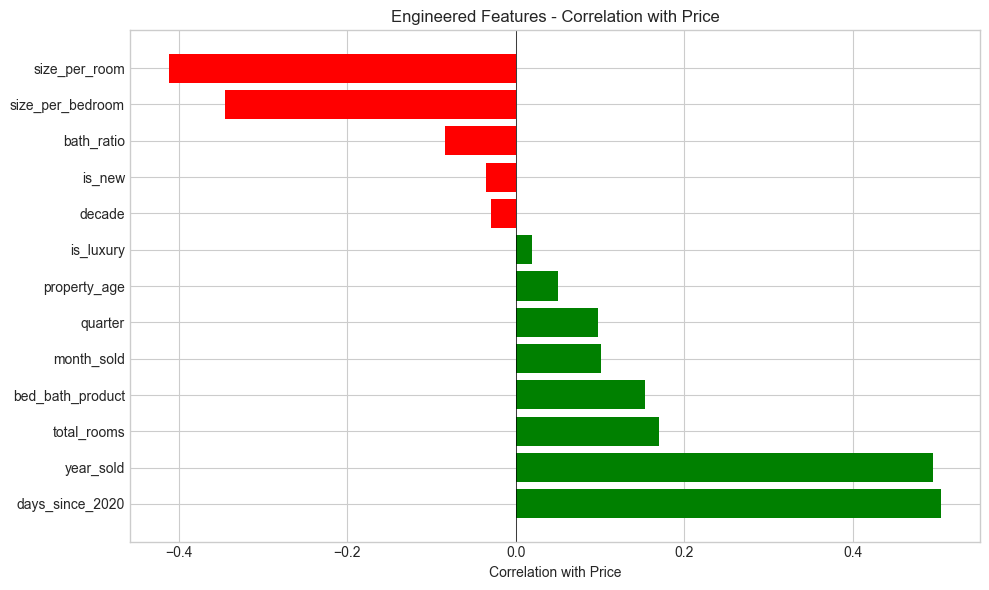

In [37]:
# visualize correlations
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations.values]
ax.barh(correlations.index, correlations.values, color=colors)
ax.set_xlabel('Correlation with Price')
ax.set_title('Engineered Features - Correlation with Price')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

## Key Insights

From our EDA and feature engineering:

1. **Time is important**: `days_since_2020` and `year_sold` show strong correlation - market appreciation is significant
2. **Spaciousness matters**: `size_per_room` and `size_per_bedroom` capture quality better than raw size
3. **Age affects value**: `property_age` shows negative correlation - newer homes sell higher
4. **Room interactions**: `bed_bath_product` captures the combined effect of bedrooms and bathrooms
5. **Luxury segment**: `is_luxury` flag helps identify premium properties

These features are used in the preprocessing pipeline (`src/preprocessing.py`) for model training.

In [38]:
print(f"\nFinal dataset shape: {data.shape}")
print(f"Original features: {len(df.columns)}")
print(f"After engineering: {len(data.columns)}")
print(f"New features added: {len(data.columns) - len(df.columns)}")


Final dataset shape: (247172, 26)
Original features: 10
After engineering: 26
New features added: 16
